# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [1]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
                 transforms.Resize(256),                      # smaller edge of image resized to 256
                 transforms.RandomCrop(224),                  # get 224x224 crop from random location
                 transforms.RandomHorizontalFlip(),           # horizontally flip image with probability=0.5
                 transforms.ToTensor(),                       # convert the PIL Image to a tensor
                 transforms.Normalize((0.485, 0.456, 0.406),  # normalize image for pre-trained model
                                      (0.229, 0.224, 0.225))])


#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

torch.Size([1, 640, 427, 3]) torch.Size([1, 3, 224, 224])


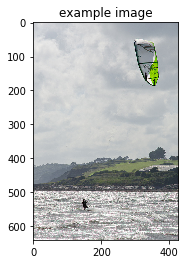

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))
print(orig_image.shape,image.shape)
# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [4]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = "encoder-1.pkl"  
decoder_file = "decoder-1.pkl"

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 66027811.13it/s]


DecoderRNN(
  (embed): Embedding(8855, 256)
  (lstm): LSTM(256, 512)
  (fc): Linear(in_features=512, out_features=8855, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [5]:
% load_ext autoreload
% autoreload 2

# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)
print("features.shape: ",features.shape)
#print("features:",features)
#print("ss:", sum(features[0][0]))

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
features.shape:  torch.Size([1, 1, 256])
input.shape   torch.Size([1, 1, 256])
len(inputs)   1
example output: [0, 3, 169, 77, 3, 335, 372, 3489, 21, 3, 112, 21, 3, 112, 21, 3, 112, 21, 3, 112]


<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [6]:
# TODO #4: Complete the function.
def clean_sentence(output):
    result = []
    voca = data_loader.dataset.vocab
    for i in output[1:]:   #skip "start word"
        result.append(voca.idx2word[i])
    return " ".join(result)

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [7]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a man in a large clock tower with a table with a table with a table with a table


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [11]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    print("features",features)
    print(type(features), features.shape)
    print("ss:", sum(features[0][0]))
    
    output = decoder.sample(features)  
    print("output", output)
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

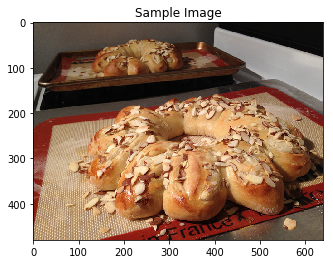

features tensor([[[ 0.4042,  0.4299, -0.3472,  0.4816, -0.2746, -0.0103, -0.3845,
           0.4018, -0.3167,  0.0197,  0.0311,  0.0631, -0.2555,  0.2598,
           0.1628,  0.2931,  0.2158, -0.0131, -0.5705, -0.1567,  0.1716,
           0.2034,  0.1074, -0.1738, -0.1317,  0.4919, -0.1087,  0.0189,
          -0.0437, -0.7272,  0.1622,  0.0836,  0.0597, -0.0506, -0.1161,
          -0.0422, -0.3345,  0.5907, -0.0300,  0.4541, -0.1526,  0.3704,
           0.5920, -0.4889,  0.2521, -0.2621, -0.3572,  0.5051,  0.3688,
           0.4458, -0.1010, -0.0580,  0.2803, -0.1466,  0.0840,  0.2958,
          -0.4772,  0.1555,  0.2493,  0.4845, -0.2637,  0.3141,  0.3664,
          -0.5123,  0.0278, -0.0463, -0.1404, -0.4727, -0.1175, -0.1278,
          -0.2373, -0.4946, -0.0550,  0.0366, -0.1288, -0.0872, -0.2366,
           0.1477,  0.3076,  0.1438,  0.0695, -0.7506, -1.1739,  0.5346,
           0.2595, -0.0142,  0.5348,  0.1824, -0.4177, -0.0232,  0.1309,
           0.1850,  0.0335,  0.2519, -0.52

In [12]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

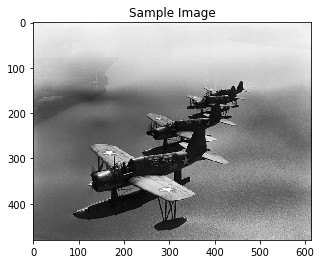

features tensor([[[ 0.0935,  0.3599,  0.3310,  0.0327, -0.1727,  0.0961, -0.3505,
           0.5254,  0.3165, -0.2085,  0.2324,  0.2554,  0.2257, -0.0864,
           0.1990,  0.2343,  0.1888, -0.2495, -0.9446, -0.0471, -0.1031,
          -0.1481,  0.3783, -0.2023, -0.1048,  0.1914, -0.4080, -0.2148,
           0.1237, -0.1728, -0.1041, -0.1736,  0.2829,  0.0616,  0.1309,
           0.1797, -0.2765,  0.3979, -0.1049,  0.4841, -0.1238,  0.1975,
           0.7084, -0.5805,  0.3017, -0.2657, -0.2068,  0.4908,  0.3701,
          -0.0385, -0.2473, -0.3475, -0.0092, -0.2809,  0.2361, -0.1522,
          -0.4111,  0.5256, -0.3034,  0.2002, -0.3389,  0.3383, -0.1492,
          -0.3159,  0.2108,  0.0663, -0.1906, -0.4352,  0.4229, -0.3347,
          -0.2331, -0.4147, -0.2251,  0.1106, -0.1351,  0.0538,  0.2471,
          -0.3333,  0.3124, -0.1213, -0.0949, -0.5432, -0.5587,  0.5918,
           0.4384,  0.2654,  0.3529,  0.3674, -0.0885, -0.2620, -0.1097,
           0.1043, -0.1797, -0.1587, -0.15

In [13]:
get_prediction()

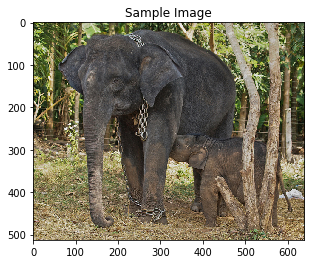

features tensor([[[ 0.7098,  0.2054,  0.1697,  0.2843, -0.1008,  0.1972, -0.0770,
           0.1282, -0.2960, -0.2560, -0.1165, -0.0892,  0.2787, -0.4243,
           0.4407,  0.0785, -0.2625,  0.0818, -0.6376,  0.5235,  0.0552,
          -0.1608,  0.4576, -0.2661, -0.5610,  0.2295, -0.2602, -0.1341,
           0.0614, -0.2376,  0.0697,  0.4877,  0.2538,  0.1431,  0.1343,
           0.2325, -0.2538,  0.0647,  0.2494,  0.8075, -0.5814,  0.0089,
           0.5614, -0.4654, -0.1054, -0.1686, -0.0773,  0.7868,  0.1041,
           0.0076, -0.2270, -0.0838,  0.5219,  0.0563,  0.1656, -0.4965,
          -0.3127,  0.5410,  0.1028,  0.3658, -0.9590, -0.1130, -0.2873,
           0.0682, -0.2057, -0.1847,  0.2130,  0.1280,  0.6038, -0.0725,
          -0.1238, -0.5655, -0.1342,  0.1624, -0.1174,  0.1895, -0.0271,
           0.1571,  0.6166, -0.0164, -0.2846, -0.3460, -0.7875,  0.7682,
           0.2371, -0.2605,  0.3754,  0.2934,  0.0296, -0.1211,  0.2053,
           0.2817,  0.2178,  0.3866, -0.67

In [14]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

In [ ]:
get_prediction()

In [ ]:
get_prediction()